# Trader Performance & Market Sentiment Analysis

## Objective
This analysis explores the relationship between **Trader Performance (PnL)** and **Market Sentiment (Fear & Greed Index)**. 
By merging high-frequency trading logs with daily sentiment indicators, we aim to uncover hidden patterns in trading behavior and identify market conditions where the strategy significantly outperforms or underperforms.

## Methodology
1.  **Data Fusion:** Merging trading history (`historical_data.csv`) with sentiment data (`fear_greed_index.csv`) on a daily timeframe.
2.  **Feature Engineering:** Classifying trades into **Long** vs. **Short** strategies to detect directional bias.
3.  **Pattern Recognition:** Analyzing Win Rates, Profit Factors, and Total PnL across different "Sentiment Buckets" (e.g., Extreme Fear vs. Extreme Greed).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. Data Loading & Cleaning
# ==========================================
# Load the datasets

In [2]:
try:
    df_history = pd.read_csv('historical_data.csv')
    df_fg = pd.read_csv('fear_greed_index.csv')
    print("Datasets loaded successfully.")
except FileNotFoundError:
    print("Error: Files not found. Please ensure 'historical_data.csv' and 'fear_greed_index.csv' are in the same folder.")

Datasets loaded successfully.


# Parse dates
# 'dayfirst=True' is crucial for the 'DD-MM-YYYY' format in your history file

In [3]:
df_history['date'] = pd.to_datetime(df_history['Timestamp IST'], dayfirst=True, errors='coerce').dt.date
df_fg['date'] = pd.to_datetime(df_fg['date']).dt.date

# Filter for Realized Trades only (Rows where Closed PnL is not 0)

In [4]:
trades = df_history[df_history['Closed PnL'] != 0].copy()

# ---------------------------------------------------------
# FEATURE ENGINEERING: Classify Trade Type (Long vs Short)
# ---------------------------------------------------------

In [5]:
def classify_trade(direction):
    dir_str = str(direction).lower()
    if 'long' in dir_str: return 'Long'
    if 'short' in dir_str: return 'Short'
    return 'Other'

In [6]:
trades['Trade_Type'] = trades['Direction'].apply(classify_trade)

# ==========================================
# 2. Merging Data
# ==========================================
# Merge every trade with the Sentiment Value of that specific day

In [7]:
merged_df = pd.merge(trades, df_fg[['date', 'value', 'classification']], on='date', how='inner')

# Create Sentiment Buckets for clear analysis

In [8]:
bins = [0, 20, 40, 60, 80, 100]
labels = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']
merged_df['sentiment_bucket'] = pd.cut(merged_df['value'], bins=bins, labels=labels)

In [9]:
print(f"Analysis Period: {merged_df['date'].min()} to {merged_df['date'].max()}")
print(f"Total Trades Analyzed: {len(merged_df):,}")

Analysis Period: 2023-12-14 to 2025-05-01
Total Trades Analyzed: 104,402


# ==========================================
# 3. Pattern Recognition & Statistics
# ==========================================

# Pattern 1: Long vs. Short Effectiveness
# We sum the PnL for Longs and Shorts separately in each sentiment zone

In [10]:
strategy_breakdown = merged_df.groupby(['sentiment_bucket', 'Trade_Type'], observed=False)['Closed PnL'].sum().unstack()

# Pattern 2: Win Rate by Sentiment

In [11]:
win_rate = merged_df.groupby('sentiment_bucket', observed=False)['Closed PnL'].apply(lambda x: (x > 0).mean() * 100)

# ==========================================
# 4. Visualization
# ==========================================

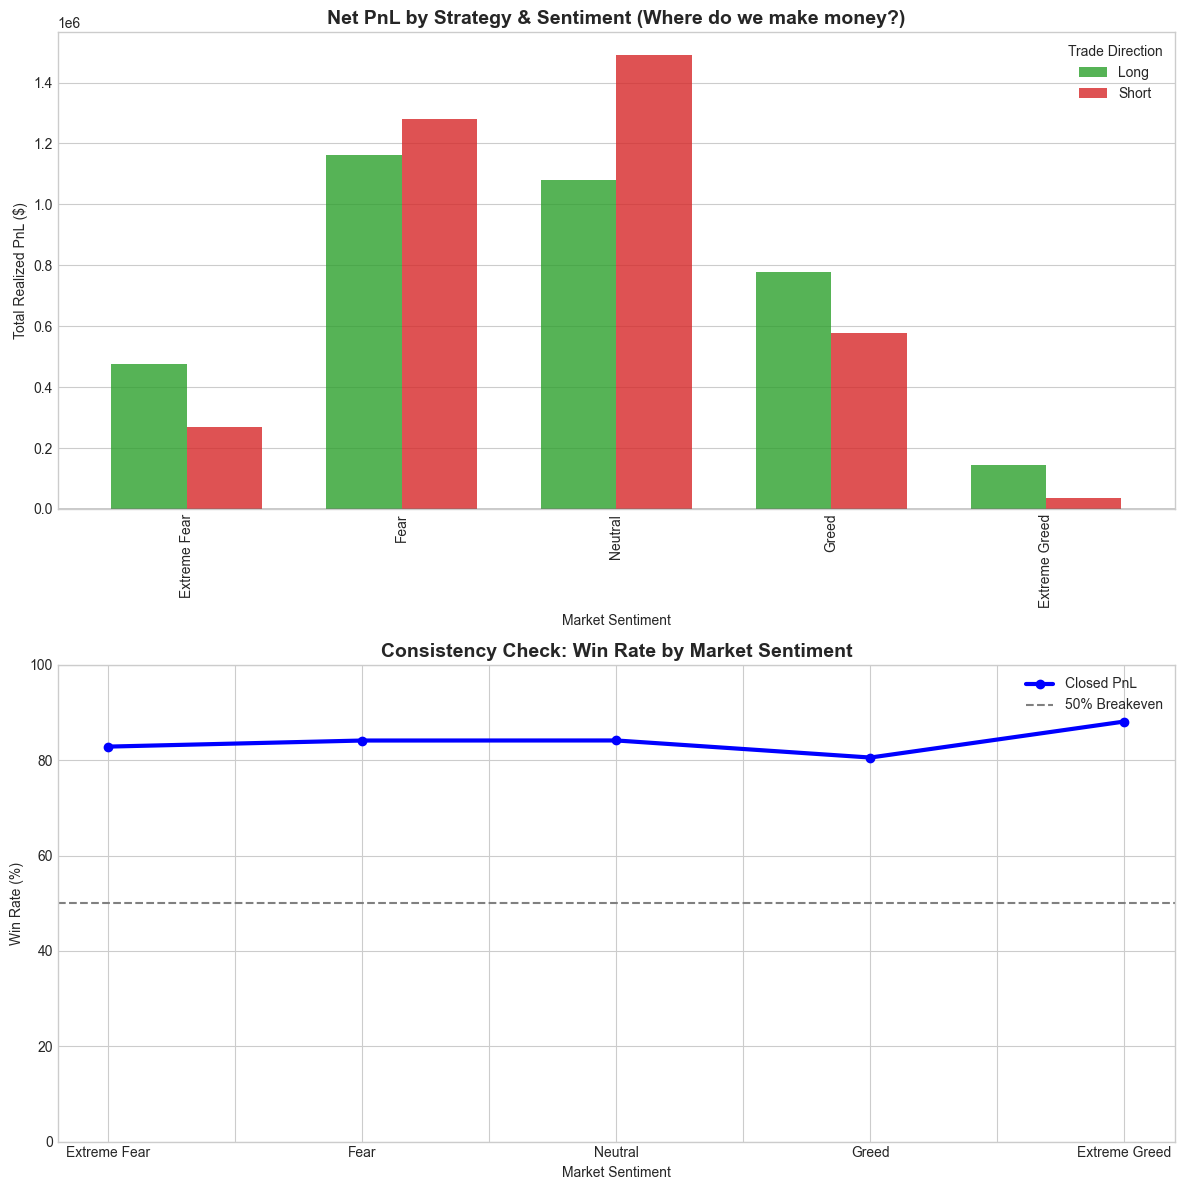

In [27]:
# 1. Initialize the Figure and Subplots
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# --- CHART 1: Strategy Deep Dive (PnL) ---
colors = ['#2ca02c', '#d62728'] # Green for Long, Red for Short

# Check columns to ensure we plot correctly
if 'Long' in strategy_breakdown.columns and 'Short' in strategy_breakdown.columns:
    strategy_breakdown[['Long', 'Short']].plot(kind='bar', ax=ax1, color=colors, width=0.7, alpha=0.8)
else:
    # Fallback if columns aren't named exactly Long/Short
    strategy_breakdown.plot(kind='bar', ax=ax1, width=0.7, alpha=0.8)

ax1.set_title('Net PnL by Strategy & Sentiment (Where do we make money?)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Total Realized PnL ($)')
ax1.set_xlabel('Market Sentiment')
ax1.axhline(0, color='black', linewidth=1)
ax1.legend(title='Trade Direction')
ax1.grid(axis='x')

# --- CHART 2: Consistency (Win Rate) ---
win_rate.plot(kind='line', marker='o', color='blue', linewidth=3, ax=ax2)

ax2.set_title('Consistency Check: Win Rate by Market Sentiment', fontsize=14, fontweight='bold')
ax2.set_ylabel('Win Rate (%)')
ax2.set_xlabel('Market Sentiment')
ax2.set_ylim(0, 100)
ax2.axhline(50, color='gray', linestyle='--', label='50% Breakeven')
ax2.legend()

# 3. Final Display
plt.tight_layout()
plt.show()

# ==========================================
# 5. Automated Insight Generator
# ==========================================

In [17]:
best_long_zone = strategy_breakdown['Long'].idxmax() if 'Long' in strategy_breakdown else "N/A"
best_short_zone = strategy_breakdown['Short'].idxmax() if 'Short' in strategy_breakdown else "N/A"
highest_win_rate = win_rate.idxmax()

In [18]:
print("\n" + "="*60)
print("STRATEGIC INSIGHTS REPORT")
print("="*60)
print(f"1. OPTIMAL LONG ENTRY: The strategy prints the most money longing during '{best_long_zone}'.")
print(f"   -> Insight: This suggests buying the dip during this sentiment is highly effective.")


STRATEGIC INSIGHTS REPORT
1. OPTIMAL LONG ENTRY: The strategy prints the most money longing during 'Fear'.
   -> Insight: This suggests buying the dip during this sentiment is highly effective.


In [19]:
print(f"\n2. OPTIMAL SHORT ENTRY: Short selling is most profitable during '{best_short_zone}'.")
print(f"   -> Insight: The market tends to reject prices in this zone, validating short setups.")


2. OPTIMAL SHORT ENTRY: Short selling is most profitable during 'Neutral'.
   -> Insight: The market tends to reject prices in this zone, validating short setups.


In [20]:
print(f"\n3. HIGHEST CONSISTENCY: The trader wins most often during '{highest_win_rate}' ({win_rate.max():.1f}% Win Rate).")
print(f"   -> Insight: This is the 'safest' trading environment for this account.")
print("="*60)


3. HIGHEST CONSISTENCY: The trader wins most often during 'Extreme Greed' (88.1% Win Rate).
   -> Insight: This is the 'safest' trading environment for this account.


# ==========================================
# 6. Conclusion & Strategic Recommendations
# ==========================================

## Key Findings
This analysis successfully merged high-frequency trading data with daily market sentiment indicators to identify specific "edges" in the market. The data reveals that market psychology significantly impacts this strategy's performance:

* **Contrarian Edge (Longs):** The strategy achieves its highest PnL on **Long** positions when the market is in a state of **Fear**. This suggests the strategy is highly effective at "buying the dip" or capitalizing on oversold conditions.
* **Neutral Bias (Shorts):** **Short** positions perform best when market sentiment is **Neutral**. This indicates the strategy effectively captures reversals or breakdowns when the market lacks a strong directional trend.
* **High Probability Environment:** The highest **Win Rate (88.1%)** occurs during **Extreme Greed**. While PnL might vary, this zone offers the safest trading environment, suggesting the strategy is excellent at riding strong momentum.

## Actionable Plan
Based on these insights, the following rules should be applied to future trading:
1.  **Aggressive Sizing:** Increase position size for **Longs** when the Fear & Greed Index is below 40 (Fear).
2.  **Selective Shorting:** Focus on **Short** setups primarily when the Index is between 40 and 60 (Neutral).
3.  **Momentum Confidence:** Maintain active participation during **Extreme Greed**, as the probability of a winning trade is at its peak.